# Reading Data from GOES-16

Sources related to variable:
- https://www.noaasis.noaa.gov/GOES/PS_PVR2.html
- https://noaa-goes16.s3.amazonaws.com/index.html

Code references:
- https://www.star.nesdis.noaa.gov/atmospheric-composition-training/python_abi_lat_lon.php
- https://github.com/HamedAlemo/visualize-goes16/blob/main/visualize_GOES16_from_AWS.ipynb
- https://www.goes-r.gov/downloads/resources/documents/Beginners_Guide_to_GOES-R_Series_Data.pdf

In [ ]:
import xarray as xr
import requests
import netCDF4
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
# Path to a folder on your computer where you want to export the data (do not include a slash at the end)
# Example: folder = 'contents'
folder = 'data'

# Name of the variable you are looking at
# Example: product_name = 'ABI-L2-RRQPEF'
product_name = 'ABI-L2-RRQPEF'

# Set the date and time you will look at (data for each time is downloaded separately)
year = 2024
day_of_year = 268 # This is the 268th day of the year (AKA September 25)
# You can use this link to check the day of year: https://nsidc.org/data/user-resources/help-center/day-year-doy-calendar
hour = 14

Run the rest of the code (no edits necessary unless you are interested in exploring more with different formats!)

In [ ]:
bucket_name = 'noaa-goes16'

# Initialize s3 client to read data directly from AWS
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket

    :param bucket: Name of the S3 bucket
    :param prefix: Only fetch keys that start with this prefix (optional)
    """

    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

# Getting the 'keys' (which are the names of files)
keys = get_s3_keys(bucket_name,
                   s3_client,
                   prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6'
                  )

# Selecting the first measurement taken within the hour
key = [key for key in keys][0]
resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')

In [ ]:
# Get the filename and read directly from AWS, without downloading
file_name = key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
ds = xr.open_dataset(store)

(-0.5, 5423.5, 5423.5, -0.5)

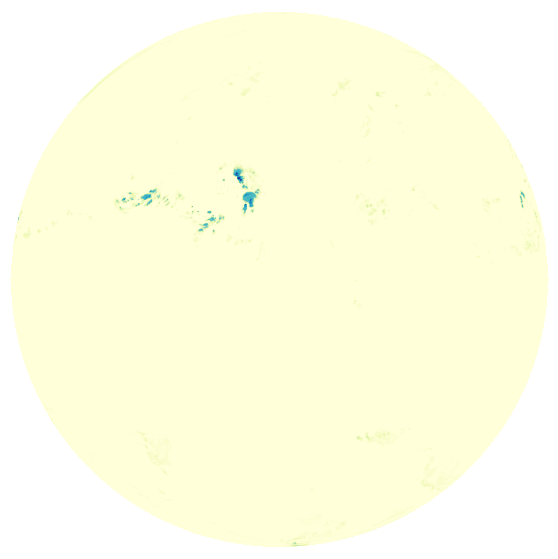

In [ ]:
# Plot the data
fig = plt.figure(figsize=(7, 7))
plt.imshow(ds.RRQPE, cmap='YlGnBu')
plt.axis('off')

In [ ]:
# Examine the dataset
ds

<xarray.Dataset> Size: 235MB
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2,
                                             number_of_LZA_bounds: 2,
                                             number_of_SZA_bounds: 2,
                                             number_of_lat_bounds: 2,
                                             number_of_rainfall_rate_bounds: 2)
Coordinates:
    t                                       datetime64[ns] 8B ...
  * y                                       (y) float32 22kB 0.1518 ... -0.1518
  * x                                       (x) float32 22kB -0.1518 ... 0.1518
    y_image                                 float32 4B ...
    x_image                                 float32 4B ...
    retrieval_local_zenith_angle            float32 4B ...
    quantitative_local_zenith_angle         float32 4B ...
    solar_zenith_angle                      float32 4B ...
    latitude                                float32 4B ...
    accounted_rainfall_rate                 float32 4B ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                number_of_LZA_bounds, number_of_SZA_bounds,
                                number_of_lat_bounds,
                                number_of_rainfall_rate_bounds
Data variables: (12/28)
    RRQPE                                   (y, x) float32 118MB nan nan ... nan
    DQF                                     (y, x) float32 118MB ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] 16B ...
    goes_imager_projection                  int32 4B ...
    y_image_bounds                          (number_of_image_bounds) float32 8B ...
    x_image_bounds                          (number_of_image_bounds) float32 8B ...
    ...                                      ...
    quantitative_local_zenith_angle_bounds  (number_of_LZA_bounds) float32 8B ...
    solar_zenith_angle_bounds               (number_of_SZA_bounds) float32 8B ...
    latitude_bounds                         (number_of_lat_bounds) float32 8B ...
    accounted_rainfall_rate_bounds          (number_of_rainfall_rate_bounds) float32 8B ...
    percent_uncorrectable_GRB_errors        float32 4B ...
    percent_uncorrectable_L0_errors         float32 4B ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2024-09-24T14:00:20.8Z
    time_coverage_end:         2024-09-24T14:09:51.6Z
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        4e352346-bbb4-43a0-a49c-686560f6875f

Right now, the data is in an xarray dataset format. We will convert it to a table with columns for latitude and longitude. This will make it easier for merging with other data later on!

In [ ]:
# Calculate latitude and longitude from GOES ABI fixed grid projection data
# GOES ABI fixed grid projection is a map projection relative to the GOES satellite
# Units: latitude in °N (°S < 0), longitude in °E (°W < 0)
# See GOES-R Product User Guide (PUG) Volume 5 (L2 products) Section 4.2.8 for details & example of calculations
# "file_id" is an ABI L1b or L2 .nc file opened using the netCDF4 library

def calculate_degrees(file_id):

    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection'].attrs
    lon_origin = projection_info['longitude_of_projection_origin']
    H = projection_info['perspective_point_height'] + projection_info['semi_major_axis']
    r_eq = projection_info['semi_major_axis']
    r_pol = projection_info['semi_minor_axis']

    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)

    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    return abi_lat, abi_lon

In [ ]:
abi_lat, abi_lon = calculate_degrees(ds)

<ipython-input-9-4dc9b71e0674>:26: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)


In [ ]:
df = pd.DataFrame({
    'latitude': abi_lat.flatten(),
    'longitude': abi_lon.flatten(),
    'precip': ds.RRQPE.values.flatten()
})

# Filter to Florida
df = df[(df['longitude'] <= -80) &
   (df['longitude'] >= -88) &
   (df['latitude'] >= 23) &
   (df['latitude'] <= 31)]

print("Number of rows:", len(df))

# Export the data
df.to_csv(f"{folder}/{product_name.replace('-','_')}_{year}_{day_of_year}_{hour}.csv", index=False)

Number of rows: 139553


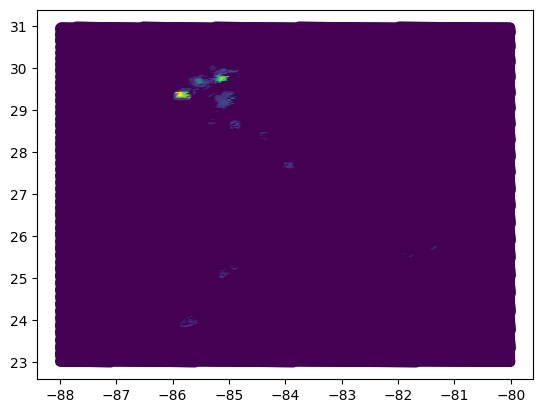

In [ ]:
plt.scatter(df['longitude'], df['latitude'], c=df['precip'])